# Getting started with qUnits

In [1]:
import qrobot
import time

## Set up a basic qBrain

First, define a sensorial input:

In [2]:
# Layer 0 - Unit 0
l0_unit0 = qrobot.qunits.SensorialUnit("l0_unit_0", Ts=0.1)

In [3]:
l0_unit0

SensorialUnit "l0_unit_0-be2d53"
     name:	l0_unit_0
     id:	l0_unit_0-be2d53
     Ts:	0.1

Then, define a model and the desired bursts:

In [4]:
qrobot.models.AngularModel(n=2, tau=10)

[model: AngularModel, n: 2, tau: 10]

In [5]:
qrobot.bursts.ZeroBurst()

In [6]:
qrobot.bursts.OneBurst()

You can use objects like those to create a basic qBrain:

<img width=300 src="./06_imgs/tutorial_qunits_basicnetwork.png"/>

In [7]:
from qrobot.models import AngularModel
from qrobot.bursts import ZeroBurst, OneBurst

# Layer 1 - Unit 0
l1_unit0 = qrobot.qunits.QUnit(
    name="l1_unit0",
    model=AngularModel(n=1, tau=10),
    burst=OneBurst(),
    Ts=0.3,
    in_qunits={0: l0_unit0.id},  # Will receive Input from l0_unit0, dim 0
)

# Layer 1 - Unit 1
l1_unit1 = qrobot.qunits.QUnit(
    name="l1_unit1",
    model=AngularModel(n=1, tau=25),
    burst=ZeroBurst(),
    Ts=0.2,
    in_qunits={0: l0_unit0.id},  # Will receive input from l0_unit0, dim 1
)

In [8]:
l1_unit0

QUnit "l1_unit0-016163"
     name:	l1_unit0
     id:	l1_unit0-016163
     model:	[model: AngularModel, n: 1, tau: 10]
     burst:	<class 'qrobot.bursts.oneburst.OneBurst'>
     query:	[0.0]
     Ts:	0.3

In [9]:
l1_unit1

QUnit "l1_unit1-c87fe1"
     name:	l1_unit1
     id:	l1_unit1-c87fe1
     model:	[model: AngularModel, n: 1, tau: 25]
     burst:	<class 'qrobot.bursts.zeroburst.ZeroBurst'>
     query:	[0.0]
     Ts:	0.2

## Inputs and queries

Check the default input for `l0_unit0`:

In [10]:
l0_unit0.scalar_reading

0.0

The input units for each qUnit are:

In [11]:
print(l1_unit0.in_qunits)
print(l1_unit1.in_qunits)

{0: 'l0_unit_0-be2d53'}
{0: 'l0_unit_0-be2d53'}


Modify `l1_unit1` query:

In [12]:
l1_unit1.query = 0.8

## Realt-time processing

In [13]:
l0_unit0.start()
l1_unit0.start()
l1_unit1.start()

2022-10-05 00:05:09,180 — l0_unit_0-be2d53 — INFO — start:73 — Starting unit
2022-10-05 00:05:09,192 — l1_unit0-016163 — INFO — start:73 — Starting unit
2022-10-05 00:05:09,204 — l1_unit1-c87fe1 — INFO — start:73 — Starting unit


Visualize the time evolution of the system from the redis status for 30 seconds changing the input with a random input:

In [14]:
import time
import json
from random import randint
from IPython.display import clear_output

statuses = []
refresh_time = 0.05  # Read statuses every 0.05 seconds

for i in range(int(30 * (1 / refresh_time))):
    time.sleep(refresh_time)

    # Change input every 2 second
    if (i * refresh_time) % 2 == 0:
        l0_unit0.scalar_reading = randint(0, 1000) / 1000

    # Read statused and store it
    status = qrobot.qunits.redis_utils.redis_status()
    statuses.append(status)

    # Print output
    clear_output(wait=True)
    print(json.dumps(status, indent=1, sort_keys=True))
    print(int(i * refresh_time), "/30 seconds")

{
 "l0_unit_0-be2d53": "0.842",
 "l1_unit0-016163": "0.0",
 "l1_unit0-016163 state": "0",
 "l1_unit1-c87fe1": "1.0",
 "l1_unit1-c87fe1 state": "0"
}
29 /30 seconds


Stop the processing loops:

In [18]:
l0_unit0.stop()
l1_unit0.stop()
l1_unit1.stop()

2022-10-05 00:05:46,633 — l0_unit_0-be2d53 — INFO — stop:81 — Stopping SensorialUnit
2022-10-05 00:05:46,640 — l1_unit0-016163 — INFO — stop:81 — Stopping QUnit
2022-10-05 00:05:46,646 — l1_unit1-c87fe1 — INFO — stop:81 — Stopping QUnit


Flush the redis to clean all traces (should not be necessary if the qUnits processing loops stopped correctly):

In [29]:
qrobot.qunits.redis_utils.redis_status()

{}

In [20]:
qrobot.qunits.redis_utils.flush_redis()

2022-10-05 00:05:46,669 — redis — INFO — flush_redis:81 — Flushing redis database


## Visualize the results

We can visualize the time evolution of such time period:

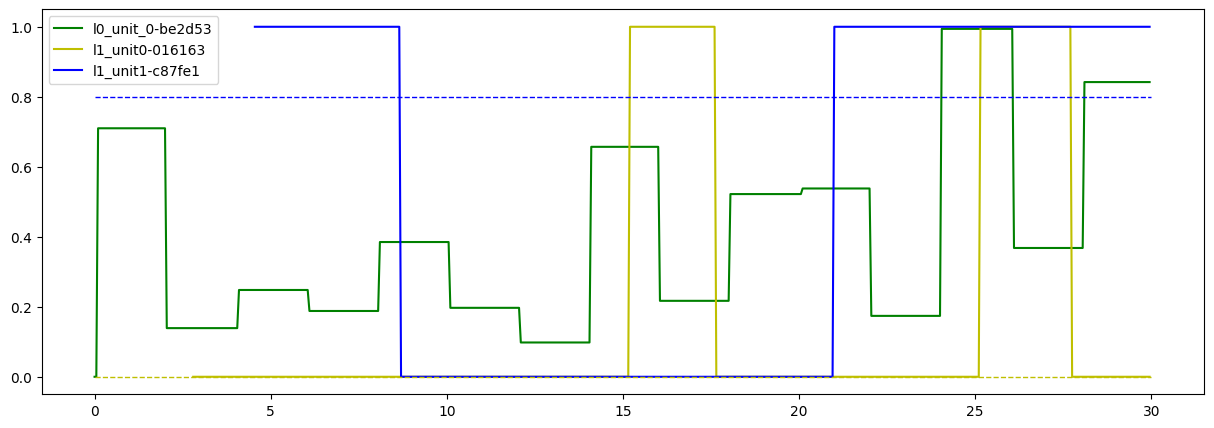

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

status_df = pd.DataFrame(statuses).astype(np.float64)
status_df.index = status_df.index * refresh_time

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Plot time evolution
units = [l0_unit0.id, l1_unit0.id, l1_unit1.id]
styles = ["g", "y", "b"]
status_df[units].plot(style=styles, ax=ax)
# Plot queries as dashed lines
ax.hlines(
    y=l1_unit0.query, xmin=0, xmax=30, linewidth=1, color="y", linestyles="dashed"
)
ax.hlines(
    y=l1_unit1.query, xmin=0, xmax=30, linewidth=1, color="b", linestyles="dashed"
)

Focusing on `l1_unit0`:

QUnit "l1_unit0-016163"
     name:	l1_unit0
     id:	l1_unit0-016163
     model:	[model: AngularModel, n: 1, tau: 10]
     burst:	<class 'qrobot.bursts.oneburst.OneBurst'>
     query:	[0.0]
     Ts:	0.3


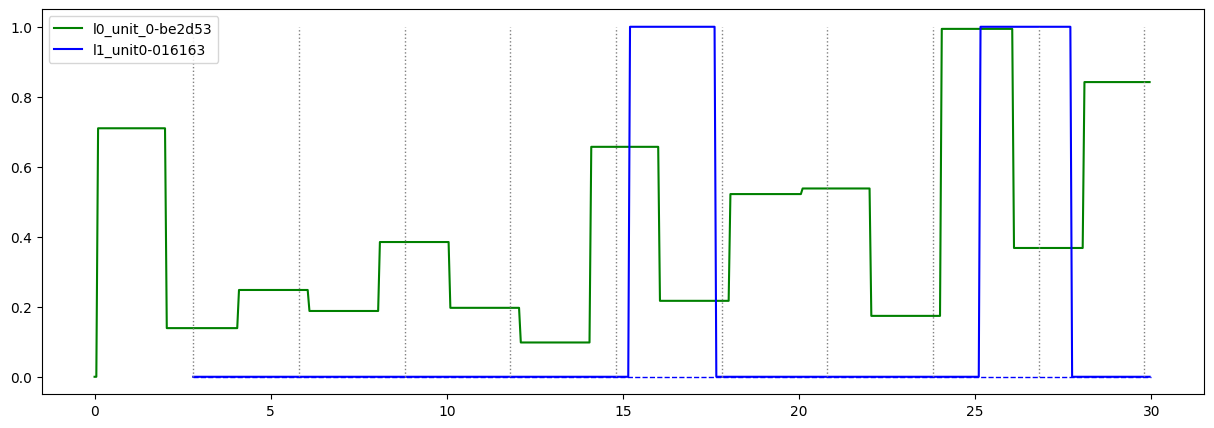

In [25]:
print(l1_unit0)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Plot time evolution
units = [l0_unit0.id, l1_unit0.id]
styles = ["g", "b"]
status_df[units].plot(style=styles, ax=ax)
# Plot time windows
t_start = status_df[l1_unit0.id].dropna().index[0]
t_step = l1_unit0.model.tau * l1_unit0.Ts
t_windows = np.arange(t_start, 31, t_step)
plt.vlines(x=t_windows, ymin=0, ymax=1, colors="gray", ls="dotted", lw=1)
# Plot query as dashed line
ax.hlines(y=l1_unit0.query, xmin=t_start, xmax=30, linewidth=1, color="b", ls="dashed")

Focusing on `l1_unit1`:

QUnit "l1_unit1-c87fe1"
     name:	l1_unit1
     id:	l1_unit1-c87fe1
     model:	[model: AngularModel, n: 1, tau: 25]
     burst:	<class 'qrobot.bursts.zeroburst.ZeroBurst'>
     query:	[0.8]
     Ts:	0.2


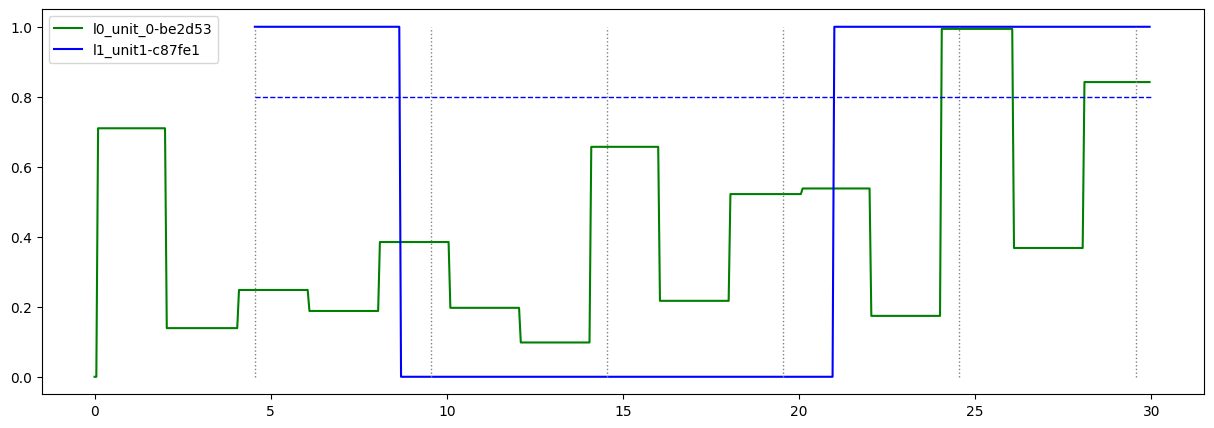

In [26]:
print(l1_unit1)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Plot time evolution
units = [l0_unit0.id, l1_unit1.id]
styles = ["g", "b"]
status_df[units].plot(style=styles, ax=ax)
# Plot time windows
t_start = status_df[l1_unit1.id].dropna().index[0]
t_step = l1_unit1.model.tau * l1_unit1.Ts
t_windows = np.arange(t_start, 31, t_step)
plt.vlines(x=t_windows, ymin=0, ymax=1, colors="gray", ls="dotted", lw=1)
# Plot query as dashed line
ax.hlines(y=l1_unit1.query, xmin=t_start, xmax=30, linewidth=1, color="b", ls="dashed")

## Detailed logs

Print the last 30 lines of the log:

In [21]:
def print_log(filter_by: "list[str]" = None, n_lines: int = 30):
    log_file = qrobot._logger.log_file()
    i = 0
    with open(log_file) as log:
        for line in log.readlines()[-n_lines:]:
            if filter_by is None or all(x in line for x in filter_by):
                print(line, end="")
                i += 1
            if i >= n_lines:
                break


print_log()

2022-10-05 00:05:46,065 — l1_unit0-016163 — DEBUG — _unit_task:215 — input_vector=[0.842]
2022-10-05 00:05:46,098 — l0_unit_0-be2d53 — DEBUG — _unit_task:79 — scalar_reading=0.842
2022-10-05 00:05:46,098 — l0_unit_0-be2d53 — DEBUG — _unit_task:80 — Writing input on redis
2022-10-05 00:05:46,117 — l1_unit1-c87fe1 — DEBUG — _unit_task:210 — Temporal window event 3/25
2022-10-05 00:05:46,118 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.842]
2022-10-05 00:05:46,201 — l0_unit_0-be2d53 — DEBUG — _unit_task:79 — scalar_reading=0.842
2022-10-05 00:05:46,201 — l0_unit_0-be2d53 — DEBUG — _unit_task:80 — Writing input on redis
2022-10-05 00:05:46,302 — l0_unit_0-be2d53 — DEBUG — _unit_task:79 — scalar_reading=0.842
2022-10-05 00:05:46,303 — l0_unit_0-be2d53 — DEBUG — _unit_task:80 — Writing input on redis
2022-10-05 00:05:46,319 — l1_unit1-c87fe1 — DEBUG — _unit_task:210 — Temporal window event 4/25
2022-10-05 00:05:46,321 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=

Print the last lines of the log only for `l1_unit1`:

In [27]:
print_log(["l1_unit1"], 200)

2022-10-05 00:05:41,602 — l1_unit1-c87fe1 — DEBUG — _unit_task:210 — Temporal window event 6/25
2022-10-05 00:05:41,603 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.368]
2022-10-05 00:05:41,805 — l1_unit1-c87fe1 — DEBUG — _unit_task:210 — Temporal window event 7/25
2022-10-05 00:05:41,810 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.368]
2022-10-05 00:05:42,013 — l1_unit1-c87fe1 — DEBUG — _unit_task:210 — Temporal window event 8/25
2022-10-05 00:05:42,016 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.368]
2022-10-05 00:05:42,219 — l1_unit1-c87fe1 — DEBUG — _unit_task:210 — Temporal window event 9/25
2022-10-05 00:05:42,221 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.368]
2022-10-05 00:05:42,422 — l1_unit1-c87fe1 — DEBUG — _unit_task:210 — Temporal window event 10/25
2022-10-05 00:05:42,424 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.368]
2022-10-05 00:05:42,627 — l1_unit1-c87fe1 — DEBUG — _unit_task:210 — 

In [23]:
print("Sampling time:", l1_unit1.Ts, "seconds")
print_log(["l1_unit1", "input_vector"], 300)

Sampling time: 0.2 seconds
2022-10-05 00:05:39,119 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:39,321 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:39,526 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:39,730 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:39,939 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:40,144 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:40,347 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:40,575 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:40,780 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:40,984 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — input_vector=[0.994]
2022-10-05 00:05:41,192 — l1_unit1-c87fe1 — DEBUG — _unit_task:215 — inpu

In [28]:
print("Time window time:", l1_unit1.Ts * l1_unit1.model.tau, "seconds")
print_log(["l1_unit1", "Output state = "], 1000)

Time window time: 5.0 seconds
2022-10-05 00:05:24,815 — l1_unit1-c87fe1 — DEBUG — _unit_task:228 — Output state = 1
2022-10-05 00:05:29,992 — l1_unit1-c87fe1 — DEBUG — _unit_task:228 — Output state = 1
2022-10-05 00:05:35,190 — l1_unit1-c87fe1 — DEBUG — _unit_task:228 — Output state = 0
2022-10-05 00:05:40,367 — l1_unit1-c87fe1 — DEBUG — _unit_task:228 — Output state = 0
2022-10-05 00:05:45,509 — l1_unit1-c87fe1 — DEBUG — _unit_task:228 — Output state = 0
